
# Online Retail — Pré-processamento e Clusterização

Este notebook conduz um fluxo completo de pré processamento e clusterização para o dataset **Online Retail (UCI)**:
1) **Carregamento e checagens iniciais**  
2) **Limpeza e engenharia de variáveis** (flags de cancelamento/ajuste, valor por linha, etc.)  

> Observações
> - Os métodos de clustering normalmente usam métricas que envolvem distância e minimiza a variância intra-cluster; por isso precisamos **padronizar** as features.  
> - O dataset contém registros **administrativos** (ex.: *Adjust bad debt*, *Bank charges*, **InvoiceNo** iniciando em `A` para ajustes e `C` para cancelamentos). Mantemos **flags** para transparência e **filtramos** para análises comerciais.

Link de acesso ao dataset: https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import os
import sys
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs, plot_algorithm_all_metrics_3d, plot_melhor_k_silhouette_and_sse, to_probability_simplex

In [2]:

FILE_PATH = r"/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/data/DatasetRaw/online_retail/Online Retail.xlsx"

# Leitura do Excel
df = pd.read_excel(FILE_PATH)

# Uniformização de nomes esperados
expected_cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
df = df[expected_cols]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Remoção de linhas com CustomerID nulo | somente clientes identificados serão considerados
df = df.dropna(subset=['CustomerID'])

In [4]:
# Remoção de linhas com Quantity menor ou igual a zero | somente compras válidas serão consideradas cancelamentos não são consideradas
df = df[df['Quantity'] > 0]

In [5]:
# Remoção de linhas com UnitPrice menor ou igual a zero | brindes e ajustes não devem ser considerados
df = df[df['UnitPrice'] > 0]

In [6]:
#Criando coluna TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()

In [8]:
df[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [9]:
df['CustomerID'].nunique()

4338

In [10]:
# Conversão da coluna InvoiceDate para o tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
# Definindo a data de snapshot como o dia seguinte à última data presente no dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [12]:
# Recency: dias desde a última compra de cada cliente
recency = (
    df.groupby('CustomerID')['InvoiceDate']
      .max()
      .reset_index()
      .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
recency['Recency'] = (snapshot_date - recency['LastPurchaseDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Frequency: número de faturas distintas por cliente
frequency = (
    df.groupby('CustomerID')['InvoiceNo']
      .nunique()
      .reset_index()
      .rename(columns={'InvoiceNo': 'Frequency'})
)

# Monetary: soma do valor total gasto por cliente
monetary = (
    df.groupby('CustomerID')['TotalPrice']
      .sum()
      .reset_index()
      .rename(columns={'TotalPrice': 'Monetary'})
)

# Juntar tudo em um único DataFrame RFM
rfm = (
    recency
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
    .set_index('CustomerID')
)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [13]:
# rfm: índice = CustomerID, colunas = Recency, Frequency, Monetary

scaler = MinMaxScaler()

rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

X = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)

X.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
CustomerID,,,
12346.0,0.871314,0.000000,0.275443
12347.0,0.002681,0.028846,0.015368
12348.0,0.198391,0.014423,0.006401
12349.0,0.048257,0.000000,0.006259
12350.0,0.828418,0.000000,0.001180


In [14]:
rfm_full = (
    rfm
    .join(X)  # adiciona Recency_scaled, Frequency_scaled, Monetary_scaled
)

rfm_full.head()

,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled
CustomerID,,,,,,
12346.0,326,1,77183.60,0.871314,0.000000,0.275443
12347.0,2,7,4310.00,0.002681,0.028846,0.015368
12348.0,75,4,1797.24,0.198391,0.014423,0.006401
12349.0,19,1,1757.55,0.048257,0.000000,0.006259
12350.0,310,1,334.40,0.828418,0.000000,0.001180


In [15]:
X_jsd = to_probability_simplex(X)

In [ ]:
#Estudo do melhor k para K-Means
results_k = []
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(k=k, max_iterations=7000, metric_name='euclidean_distance')
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    diffs = (X - centroids_kmeans[clusters_kmeans]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmeans)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Means"
    })
    

Convergiu na iteração 5
Convergiu na iteração 21
Convergiu na iteração 22
Convergiu na iteração 19
Convergiu na iteração 44
Convergiu na iteração 42
Convergiu na iteração 45
Convergiu na iteração 40
Convergiu na iteração 61


In [26]:
df_k_search = pd.DataFrame(results_k)
df_k_search

,k,sse_euclidean,silhouette,algoritmo
0,2,74.115508,0.722724,K-Means
1,3,40.833413,0.645018,K-Means
2,4,36.152238,0.650264,K-Means
3,5,22.695963,0.572344,K-Means
4,6,16.120427,0.560162,K-Means
5,7,14.515633,0.515062,K-Means
6,8,10.879395,0.470891,K-Means
7,9,9.506837,0.487983,K-Means
8,10,8.685207,0.425504,K-Means


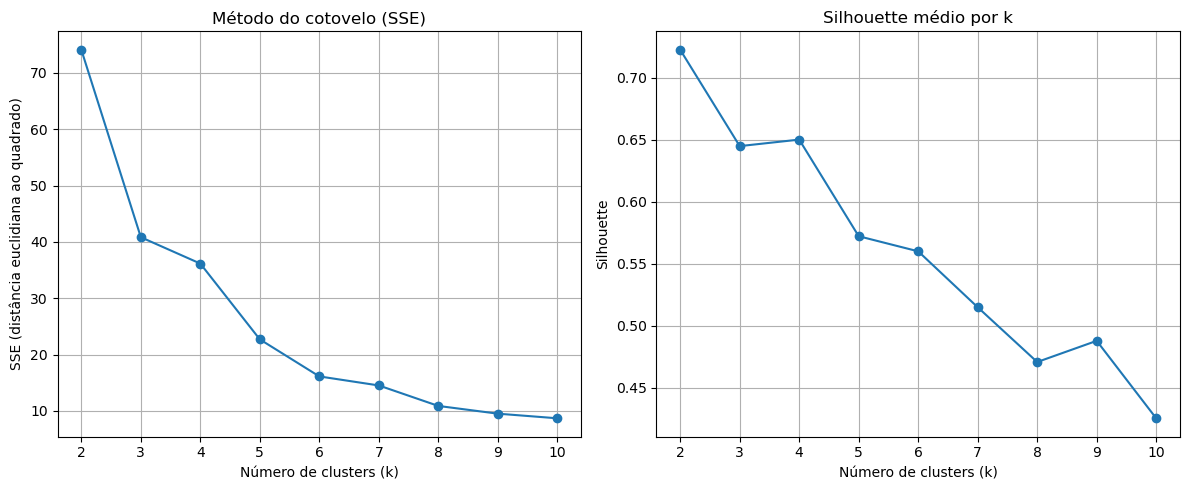

In [ ]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Means'])

In [ ]:
#Estudo do melhor k para K-medoids
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmedoids = KMedoids(k=k, max_iterations=7000, metric_name='euclidean_distance')
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    diffs = (X - centroids_kmedoids[clusters_kmedoids]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmedoids)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Medoids"
    })
    

K-Medoids convergiu na iteração 6
K-Medoids convergiu na iteração 7
K-Medoids convergiu na iteração 12
K-Medoids convergiu na iteração 14
K-Medoids convergiu na iteração 6
K-Medoids convergiu na iteração 13
K-Medoids convergiu na iteração 44
K-Medoids convergiu na iteração 46
K-Medoids convergiu na iteração 47


In [ ]:
df_k_search = pd.DataFrame(results_k)
df_k_search

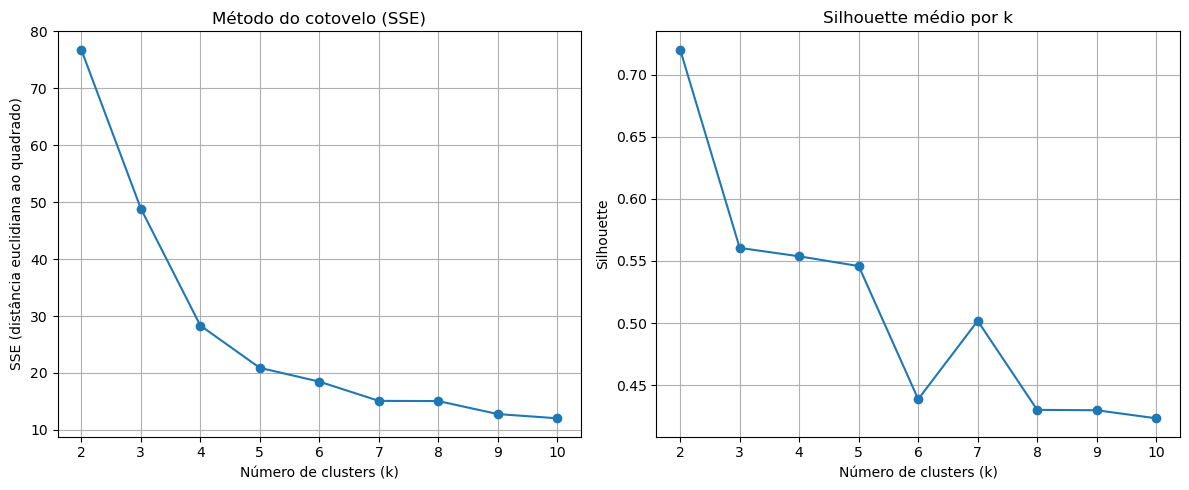

In [30]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Medoids'])

### Algoritmo: Kmeans

In [ ]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance']#, 'jensen-shannon_distance']

silhouette_metric_name = {
    'euclidean_distance': 'euclidean',
    'manhattan_distance': 'manhattan',
    'cosine_distance': 'cosine',
    'mahalanobis_distance': 'mahalanobis',
    'jensen-shannon_distance': jensenshannon
}


In [ ]:
results_kmeans = []
plots_kmeans = {}
# instaciando o KMeans
for metric_name in metrics:
    kmeans = KMeans(k=4, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    runtime_kmeans = time() - t0
    results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
    plots_kmeans[metric_name] = {
        "X": X,
        "labels": clusters_kmeans,
        "model": kmeans
    }
    print(f"KMeans com {metric_name} finalizado.")

#Jensen-Shannon Distance vai usar um X diferentekmeans = KMeans(k=3, max_iterations=7000, metric_name='jensen-shannon_distance')
kmeans = KMeans(k=3, max_iterations=7000, metric_name='jensen-shannon_distance')
t0 = time()
centroids_kmeans, clusters_kmeans = kmeans.fit(X_jsd)
runtime_kmeans = time() - t0
results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=silhouette_metric_name['jensen-shannon_distance'], runtime=runtime_kmeans, X=X_jsd, labels=clusters_kmeans))
plots_kmeans['jensen-shannon_distance'] = {
        "X": X_jsd,
        "labels": clusters_kmeans,
        "model": kmeans
    }
print(f"KMeans com jensen-shannon_distance finalizado.")

Convergiu na iteração 13
KMeans com euclidean_distance finalizado.
Convergiu na iteração 18
KMeans com manhattan_distance finalizado.
Convergiu na iteração 21
KMeans com cosine_distance finalizado.
Convergiu na iteração 26
KMeans com mahalanobis_distance finalizado.
Convergiu na iteração 26
KMeans com jensen-shannon_distance finalizado.


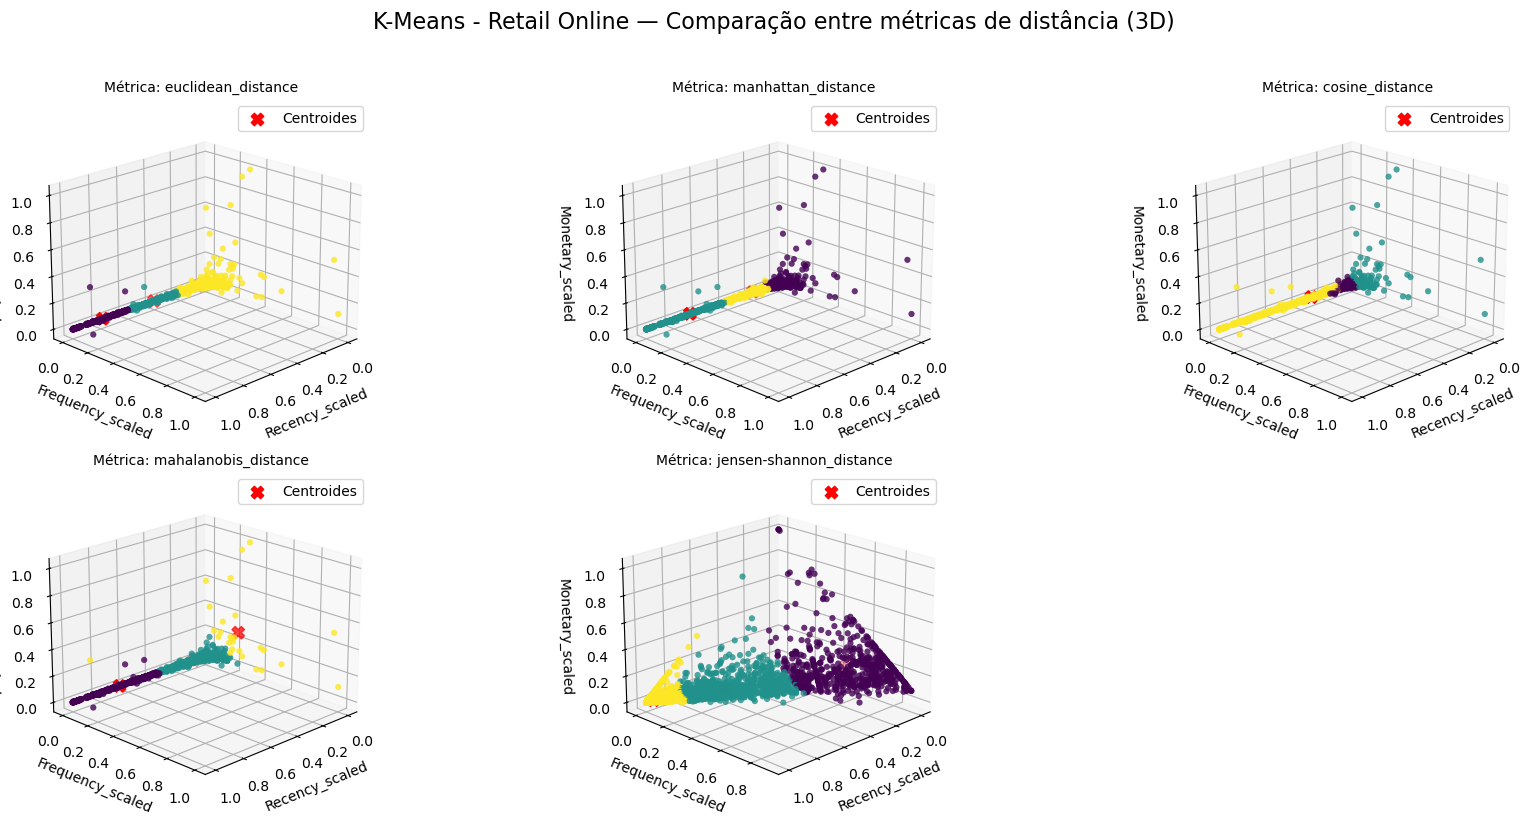

In [25]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmeans, algorithm_name="K-Means - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [19]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean_distance,4,0.782247,27.209560,0.562405,0.568701,15662.967137
1,Kmeans,manhattan_distance,4,1.403551,27.730051,0.554239,0.571408,15341.857917
2,Kmeans,cosine_distance,4,2.597009,220.819278,-0.102451,1.494070,663.352101
3,Kmeans,mahalanobis_distance,4,2.340223,69.390061,0.559955,0.879732,5263.659764
4,Kmeans,jensen-shannon_distance,3,14.400306,71.636634,0.684832,0.550825,16233.843793


In [20]:
labels_k_means_euclidean = plots_kmeans['euclidean_distance']["labels"]
labels_k_means_manhattan = plots_kmeans['manhattan_distance']["labels"]
labels_k_means_cosine = plots_kmeans['cosine_distance']["labels"]
labels_k_means_mahalanobis = plots_kmeans['mahalanobis_distance']["labels"]
labels_k_means_jsd = plots_kmeans['jensen-shannon_distance']["labels"]

rfm_k_means = rfm.copy()
rfm_k_means[f"cluster_k_means_euclidean"] = labels_k_means_euclidean
rfm_k_means[f"cluster_k_means_manhattan"] = labels_k_means_manhattan
rfm_k_means[f"cluster_k_means_cosine"] = labels_k_means_cosine
rfm_k_means[f"cluster_k_means_mahalanobis"] = labels_k_means_mahalanobis
rfm_k_means[f"cluster_k_means_jsd"] = labels_k_means_jsd
rfm_k_means.head()

,Recency,Frequency,Monetary,cluster_k_means_euclidean,cluster_k_means_manhattan,cluster_k_means_cosine,cluster_k_means_mahalanobis,cluster_k_means_jsd
CustomerID,,,,,,,,
12346.0,326,1,77183.60,2,0,1,1,2
12347.0,2,7,4310.00,1,2,2,3,1
12348.0,75,4,1797.24,0,1,1,3,2
12349.0,19,1,1757.55,1,2,1,3,2
12350.0,310,1,334.40,2,0,1,2,2


In [21]:
cluster_profile_k_means_euclidean = (
    rfm_k_means
    .groupby(f"cluster_k_means_euclidean")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_euclidean["perc_clientes"] = (
    cluster_profile_k_means_euclidean["n_clientes"] 
    / cluster_profile_k_means_euclidean["n_clientes"].sum()
)

cluster_profile_k_means_euclidean["perc_faturamento"] = (
    cluster_profile_k_means_euclidean["faturamento_total"] 
    / cluster_profile_k_means_euclidean["faturamento_total"].sum()
)

cluster_profile_k_means_euclidean

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_euclidean,,,,,,,,,,
1,2195,20.128474,18.0,6.379954,4.0,3243.533964,1161.50,7119557.051,0.505994,0.801102
0,1042,83.615163,78.0,2.616123,2.0,1004.927305,640.32,1047134.252,0.240203,0.117825
3,603,192.865672,190.0,1.873964,1.0,728.973899,353.43,439571.261,0.139004,0.049461
2,498,308.867470,305.0,1.349398,1.0,564.149257,267.88,280946.330,0.114799,0.031612


In [22]:
cluster_profile_k_means_manhattan = (
    rfm_k_means
    .groupby(f"cluster_k_means_manhattan")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_manhattan["perc_clientes"] = (
    cluster_profile_k_means_manhattan["n_clientes"] 
    / cluster_profile_k_means_manhattan["n_clientes"].sum()
)

cluster_profile_k_means_manhattan["perc_faturamento"] = (
    cluster_profile_k_means_manhattan["faturamento_total"] 
    / cluster_profile_k_means_manhattan["faturamento_total"].sum()
)

cluster_profile_k_means_manhattan

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_manhattan,,,,,,,,,,
2,2013,17.653751,17.0,6.721808,4.0,3444.346757,1258.060,6933470.021,0.464039,0.780163
1,1115,73.127354,71.0,2.654709,2.0,1027.114423,628.380,1145232.582,0.257031,0.128863
3,604,173.119205,173.0,2.016556,2.0,725.096028,391.960,437958.001,0.139235,0.049280
0,606,296.674917,288.5,1.358086,1.0,611.465825,287.285,370548.290,0.139696,0.041695


In [23]:
cluster_profile_k_means_mahalanobis = (
    rfm_k_means
    .groupby(f"cluster_k_means_mahalanobis")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_mahalanobis["perc_clientes"] = (
    cluster_profile_k_means_mahalanobis["n_clientes"] 
    / cluster_profile_k_means_mahalanobis["n_clientes"].sum()
)

cluster_profile_k_means_mahalanobis["perc_faturamento"] = (
    cluster_profile_k_means_mahalanobis["faturamento_total"] 
    / cluster_profile_k_means_mahalanobis["faturamento_total"].sum()
)

cluster_profile_k_means_mahalanobis

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_mahalanobis,,,,,,,,,,
1,8,46.875000,5.5,36.125000,38.5,164137.150000,146693.515,1313097.200,0.001844,0.147751
0,66,10.969697,3.0,44.106061,32.0,21037.709242,12827.695,1388488.810,0.015214,0.156235
3,3202,42.530606,31.0,4.259525,3.0,1741.462499,881.165,5576162.923,0.738128,0.627437
2,1062,248.720339,243.0,1.594162,1.0,573.879436,310.860,609459.961,0.244813,0.068577


In [24]:
cluster_profile_k_means_cosine = (
    rfm_k_means
    .groupby(f"cluster_k_means_cosine")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_cosine["perc_clientes"] = (
    cluster_profile_k_means_cosine["n_clientes"] 
    / cluster_profile_k_means_cosine["n_clientes"].sum()
)

cluster_profile_k_means_cosine["perc_faturamento"] = (
    cluster_profile_k_means_cosine["faturamento_total"] 
    / cluster_profile_k_means_cosine["faturamento_total"].sum()
)

cluster_profile_k_means_cosine

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_cosine,,,,,,,,,,
2,408,4.075980,3.0,16.379902,11.5,10651.342377,3892.765,4345747.690,0.094053,0.488989
0,420,12.669048,10.0,7.626190,7.0,3105.682143,2335.880,1304386.500,0.096819,0.146771
3,732,28.356557,24.0,4.829235,4.0,1795.582761,1337.450,1314366.581,0.168741,0.147894
1,2778,134.514759,96.0,1.839813,1.0,692.119555,392.190,1922708.123,0.640387,0.216346


In [25]:
cluster_profile_k_means_jsd = (
    rfm_k_means
    .groupby(f"cluster_k_means_jsd")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_jsd["perc_clientes"] = (
    cluster_profile_k_means_jsd["n_clientes"] 
    / cluster_profile_k_means_jsd["n_clientes"].sum()
)

cluster_profile_k_means_jsd["perc_faturamento"] = (
    cluster_profile_k_means_jsd["faturamento_total"] 
    / cluster_profile_k_means_jsd["faturamento_total"].sum()
)

cluster_profile_k_means_jsd

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_means_jsd,,,,,,,,,,
1,596,5.904362,4.0,13.843960,10.0,8395.937366,3447.40,5003978.670,0.137391,0.563054
0,945,24.461376,21.0,5.348148,5.0,2072.864699,1477.66,1958857.141,0.217842,0.220413
2,2797,133.996425,95.0,1.868788,1.0,688.013258,392.86,1924373.083,0.644767,0.216533


### Algoritmo: Kmedoids

In [ ]:
results_kmedoids = []
plots_kmedoids = {}
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    runtime_kmedoids = time() - t0
    results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=silhouette_metric_name[metric_name], runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
    plots_kmedoids[metric_name] = {
        "X": X,
        "labels": clusters_kmedoids,
        "model": kmedoids
    }
    print(f"KMedoids com métrica {metric_name} finalizado.")

#Jensen-Shannon Distance vai usar um X diferente
kmedoids = KMedoids(k=3, max_iterations=7000, metric_name='jensen-shannon_distance')
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X_jsd)
runtime_kmedoids = time() - t0
results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=silhouette_metric_name['jensen-shannon_distance'], runtime=runtime_kmedoids, X=X_jsd, labels=clusters_kmedoids))
plots_kmedoids['jensen-shannon_distance'] = {
        "X": X_jsd,
        "labels": clusters_kmedoids,
        "model": kmedoids
    }
print(f"KMedoids com métrica jensen-shannon_distance finalizado.")

K-Medoids convergiu na iteração 7
KMedoids com métrica euclidean_distance finalizado.
K-Medoids convergiu na iteração 28
KMedoids com métrica manhattan_distance finalizado.
K-Medoids convergiu na iteração 10
KMedoids com métrica cosine_distance finalizado.
K-Medoids convergiu na iteração 9
KMedoids com métrica mahalanobis_distance finalizado.
K-Medoids convergiu na iteração 3
KMedoids com métrica jensen-shannon_distance finalizado.


In [63]:
labels_k_medoids_euclidean = plots_kmedoids['euclidean_distance']["labels"]
labels_k_medoids_manhattan = plots_kmedoids['manhattan_distance']["labels"]
labels_k_medoids_cosine = plots_kmedoids['cosine_distance']["labels"]
labels_k_medoids_mahalanobis = plots_kmedoids['mahalanobis_distance']["labels"]
labels_k_medoids_jsd = plots_kmedoids['jensen-shannon_distance']["labels"]

rfm_k_medoids = rfm.copy()
rfm_k_medoids[f"cluster_k_medoids_euclidean"] = labels_k_medoids_euclidean
rfm_k_medoids[f"cluster_k_medoids_manhattan"] = labels_k_medoids_manhattan
rfm_k_medoids[f"cluster_k_medoids_cosine"] = labels_k_medoids_cosine
rfm_k_medoids[f"cluster_k_medoids_mahalanobis"] = labels_k_medoids_mahalanobis
rfm_k_medoids[f"cluster_k_medoids_jsd"] = labels_k_medoids_jsd
rfm_k_medoids.head()



,Recency,Frequency,Monetary,cluster_k_medoids_euclidean,cluster_k_medoids_manhattan,cluster_k_medoids_cosine,cluster_k_medoids_mahalanobis,cluster_k_medoids_jsd
CustomerID,,,,,,,,
12346.0,326,1,77183.60,2,1,1,0,1
12347.0,2,7,4310.00,1,0,0,2,0
12348.0,75,4,1797.24,0,2,1,2,1
12349.0,19,1,1757.55,1,0,1,2,2
12350.0,310,1,334.40,2,1,1,0,2


In [66]:
cluster_profile_k_medoids_euclidean = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_euclidean")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_euclidean["perc_clientes"] = (
    cluster_profile_k_medoids_euclidean["n_clientes"] 
    / cluster_profile_k_medoids_euclidean["n_clientes"].sum()
)

cluster_profile_k_medoids_euclidean["perc_faturamento"] = (
    cluster_profile_k_medoids_euclidean["faturamento_total"] 
    / cluster_profile_k_medoids_euclidean["faturamento_total"].sum()
)

cluster_profile_k_medoids_euclidean

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_euclidean,,,,,,,,,,
1,2121,19.067421,17.0,6.495992,4.0,3310.828614,1191.13,7022267.491,0.488935,0.790154
0,1273,90.281225,79.0,2.591516,2.0,993.044699,605.12,1264145.902,0.293453,0.142243
2,944,260.649364,256.0,1.541314,1.0,636.435912,306.83,600795.501,0.217612,0.067602


In [67]:
cluster_profile_k_medoids_manhattan = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_manhattan")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_manhattan["perc_clientes"] = (
    cluster_profile_k_medoids_manhattan["n_clientes"] 
    / cluster_profile_k_medoids_manhattan["n_clientes"].sum()
)

cluster_profile_k_medoids_manhattan["perc_faturamento"] = (
    cluster_profile_k_medoids_manhattan["faturamento_total"] 
    / cluster_profile_k_medoids_manhattan["faturamento_total"].sum()
)

cluster_profile_k_medoids_manhattan

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_manhattan,,,,,,,,,,
0,2117,19.025508,17.0,6.521493,4.0,3321.350662,1207.240,7031299.351,0.488013,0.791171
2,1291,90.987607,80.0,2.562355,2.0,982.675950,599.680,1268634.652,0.297603,0.142748
1,930,262.022581,257.0,1.524731,1.0,631.478377,305.515,587274.891,0.214385,0.066081


In [68]:
cluster_profile_k_medoids_cosine = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_cosine")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_cosine["perc_clientes"] = (
    cluster_profile_k_medoids_cosine["n_clientes"] 
    / cluster_profile_k_medoids_cosine["n_clientes"].sum()
)

cluster_profile_k_medoids_cosine["perc_faturamento"] = (
    cluster_profile_k_medoids_cosine["faturamento_total"] 
    / cluster_profile_k_medoids_cosine["faturamento_total"].sum()
)

cluster_profile_k_medoids_cosine

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_cosine,,,,,,,,,,
0,550,5.345455,4.0,14.309091,10.0,8741.905473,3458.345,4808048.010,0.126787,0.541008
2,595,18.368067,16.0,6.297479,6.0,2483.790134,1789.770,1477855.130,0.137160,0.166290
1,3193,121.376135,78.0,2.165675,2.0,814.690183,454.110,2601305.754,0.736053,0.292702


In [69]:
cluster_profile_k_medoids_mahalanobis= (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_mahalanobis")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_mahalanobis["perc_clientes"] = (
    cluster_profile_k_medoids_mahalanobis["n_clientes"] 
    / cluster_profile_k_medoids_mahalanobis["n_clientes"].sum()
)

cluster_profile_k_medoids_mahalanobis["perc_faturamento"] = (
    cluster_profile_k_medoids_mahalanobis["faturamento_total"] 
    / cluster_profile_k_medoids_mahalanobis["faturamento_total"].sum()
)

cluster_profile_k_medoids_mahalanobis

,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_mahalanobis,,,,,,,,,,
1,811,149.040691,150.0,3.713933,2.0,2554.400951,495.770,2071619.171,0.186953,0.233101
2,2886,32.437630,25.5,4.880804,3.0,2150.418951,957.625,6206109.093,0.665284,0.698319
0,641,291.631825,284.0,2.237129,1.0,950.827816,290.510,609480.630,0.147764,0.068580


In [65]:
cluster_profile_k_medoids_jsd = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_jsd")
    .agg(
        n_clientes=("Recency", "size"),
        recency_medio=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        frequency_media=("Frequency", "mean"),
        frequency_mediana=("Frequency", "median"),
        monetary_medio=("Monetary", "mean"),
        monetary_mediana=("Monetary", "median"),
        faturamento_total=("Monetary", "sum"),
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_jsd["perc_clientes"] = (
    cluster_profile_k_medoids_jsd["n_clientes"] 
    / cluster_profile_k_medoids_jsd["n_clientes"].sum()
)

cluster_profile_k_medoids_jsd["perc_faturamento"] = (
    cluster_profile_k_medoids_jsd["faturamento_total"] 
    / cluster_profile_k_medoids_jsd["faturamento_total"].sum()
)

cluster_profile_k_medoids_jsd


,n_clientes,recency_medio,recency_mediana,frequency_media,frequency_mediana,monetary_medio,monetary_mediana,faturamento_total,perc_clientes,perc_faturamento
cluster_k_medoids_jsd,,,,,,,,,,
0,832,8.461538,6.0,11.894231,8.0,6826.764724,2824.91,5679868.250,0.191793,0.639106
1,1353,42.462676,32.0,4.104213,4.0,1625.836084,1093.68,2199756.222,0.311895,0.247519
2,2153,156.493730,138.0,1.431955,1.0,467.990907,322.08,1007584.422,0.496312,0.113375


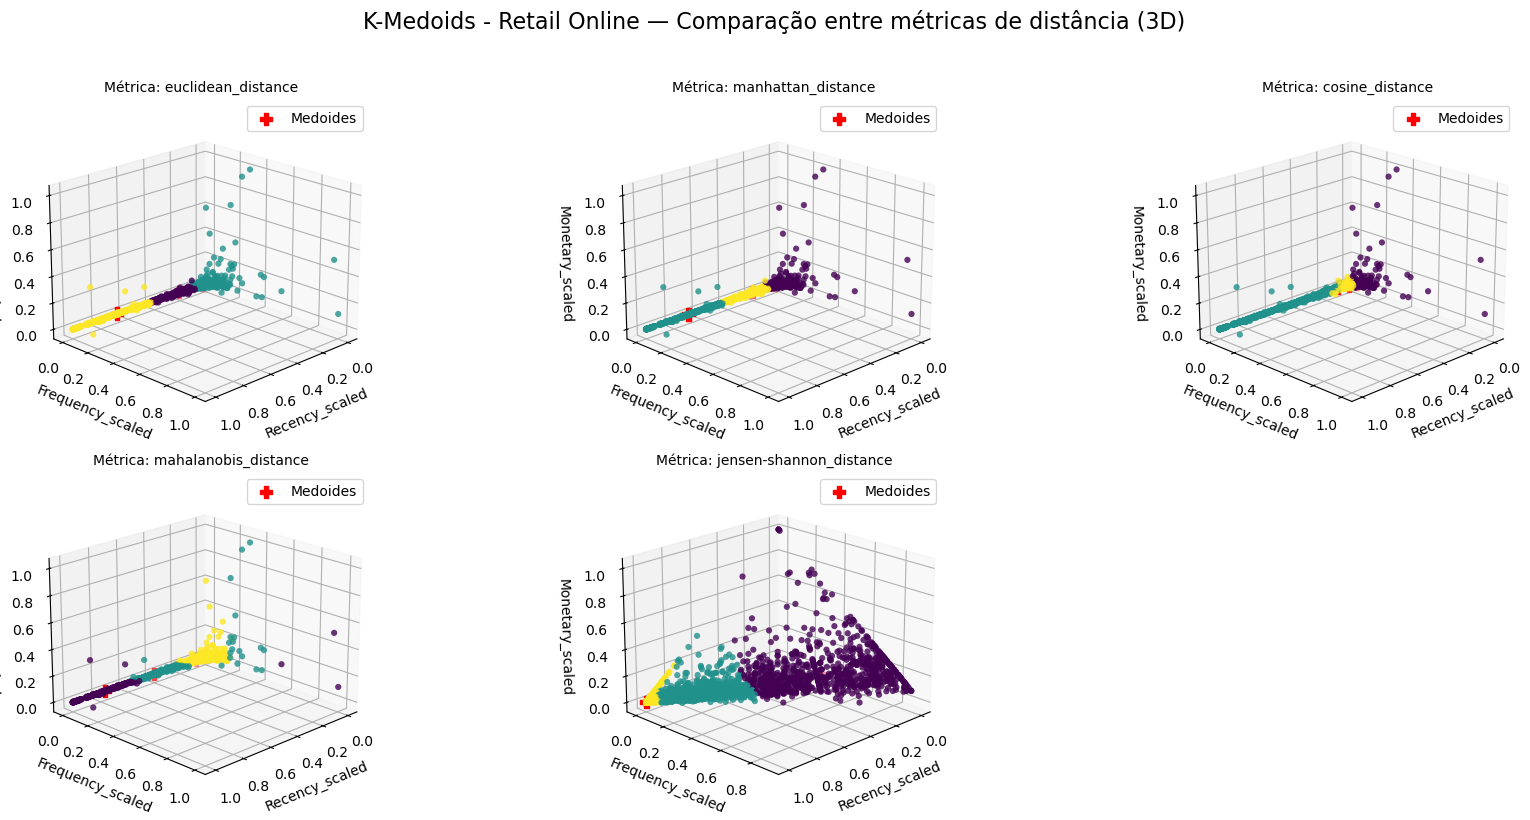

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_kmedoids.pop()
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

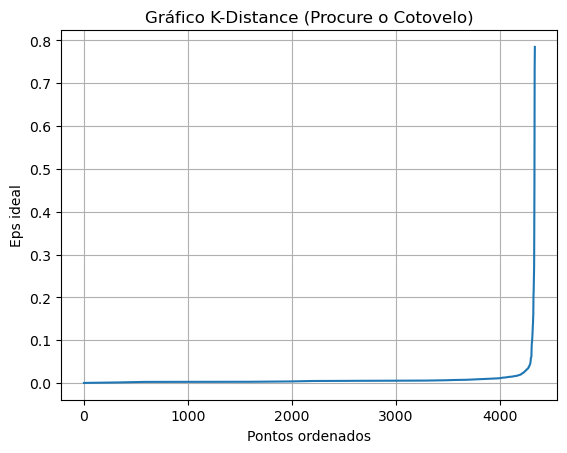

In [30]:
from sklearn.neighbors import NearestNeighbors

# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

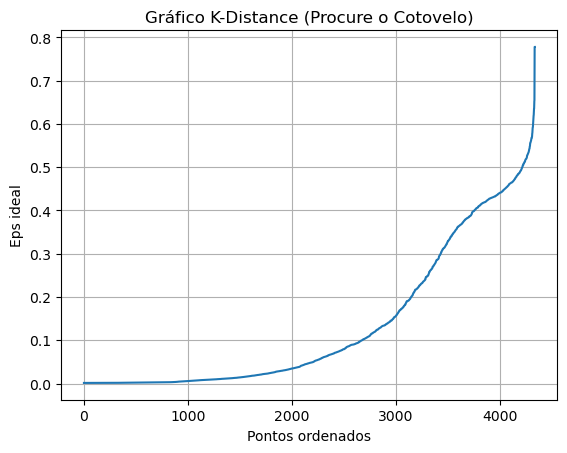

In [31]:
# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X_jsd)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

In [ ]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.012, 0.015, 0.018, 0.020, 0.022, 0.025, 0.028]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    eval_kwargs = {}
    evaluation = EvaluationMetrics(X=X, labels=db.labels_, y_true=None, metric='euclidean', **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep
    })
    print(f"DBSCAN com eps {ep} finalizado.")

In [29]:
#experimento 2
df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps
0,27,0.000078,-0.618101,DBSCAN,0.001
1,47,0.000350,-0.607744,DBSCAN,0.002
2,62,0.773243,-0.407812,DBSCAN,0.003
3,64,2.058337,-0.410158,DBSCAN,0.004
4,45,8.073089,-0.271045,DBSCAN,0.005
5,10,15.304005,-0.084640,DBSCAN,0.006
6,12,15.806691,-0.199499,DBSCAN,0.007
7,7,39.891280,-0.151154,DBSCAN,0.008
8,3,89.413703,0.276492,DBSCAN,0.009
9,3,90.629982,0.279916,DBSCAN,0.010


In [ ]:
#experimento 1
df_results_eps = pd.DataFrame(results_eps)
df_results_eps

,k,sse_euclidean,silhouette,algoritmo,eps
0,3,90.629982,0.279916,DBSCAN,0.01
1,2,242.915024,0.216933,DBSCAN,0.02
2,1,310.411295,0.401451,DBSCAN,0.03
3,1,311.151460,0.448270,DBSCAN,0.04
4,1,311.512413,0.498216,DBSCAN,0.05
5,1,311.638133,0.512737,DBSCAN,0.06
6,1,312.061650,0.536350,DBSCAN,0.07
7,1,312.748351,0.564590,DBSCAN,0.08
8,1,312.850470,0.572652,DBSCAN,0.09
9,1,313.242872,0.595256,DBSCAN,0.10


In [ ]:
#Estudo do melhor eps para DBSCAN com JSD

eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='jensen-shannon_distance')
    db.fit(X_jsd)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    evaluation = EvaluationMetrics(X=X_jsd, labels=db.labels_, y_true=None, metric=silhouette_metric_name['jensen-shannon_distance'], **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_jensen_shannon": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep
    })
    print(f"DBSCAN com eps {ep} finalizado.")

In [ ]:
#results_kmedoids.pop()
df_results_eps = pd.DataFrame(results_kmedoids)
df_results_kmedoids

### Algoritmo: DBSCAN

In [ ]:
results_dbscan = []
plots_dbscan = {}
# instaciando o DBSCAN
for metric_name in metrics:
    if metric_name == 'jensen-shannon_distance':
        dbscan = DBSCAN(eps=0.04, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X_jsd)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        dataset = pd.concat(
            [pd.DataFrame(X_jsd), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
        # filtra fora os outliers (cluster == -1)
        dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
        X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
        labels_inliers = np.asarray(dataset_filtrado['cluster'])
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X_jsd,
            "labels": labels_dbscan,
            "model": dbscan
        }
    else:
        dbscan = DBSCAN(eps=0.04, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        dataset = pd.concat(
            [pd.DataFrame(X), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
        # filtra fora os outliers (cluster == -1)
        dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
        X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
        labels_inliers = np.asarray(dataset_filtrado['cluster'])
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X,
            "labels": labels_dbscan,
            "model": dbscan
        }
    
    print(f"dbscan com {metric_name} finalizado.")

DBSCAN com métrica euclidean_distance finalizado.
DBSCAN com métrica manhattan_distance finalizado.
DBSCAN com métrica cosine_distance finalizado.
DBSCAN com métrica mahalanobis_distance finalizado.
DBSCAN com métrica jensen-shannon_distance finalizado.


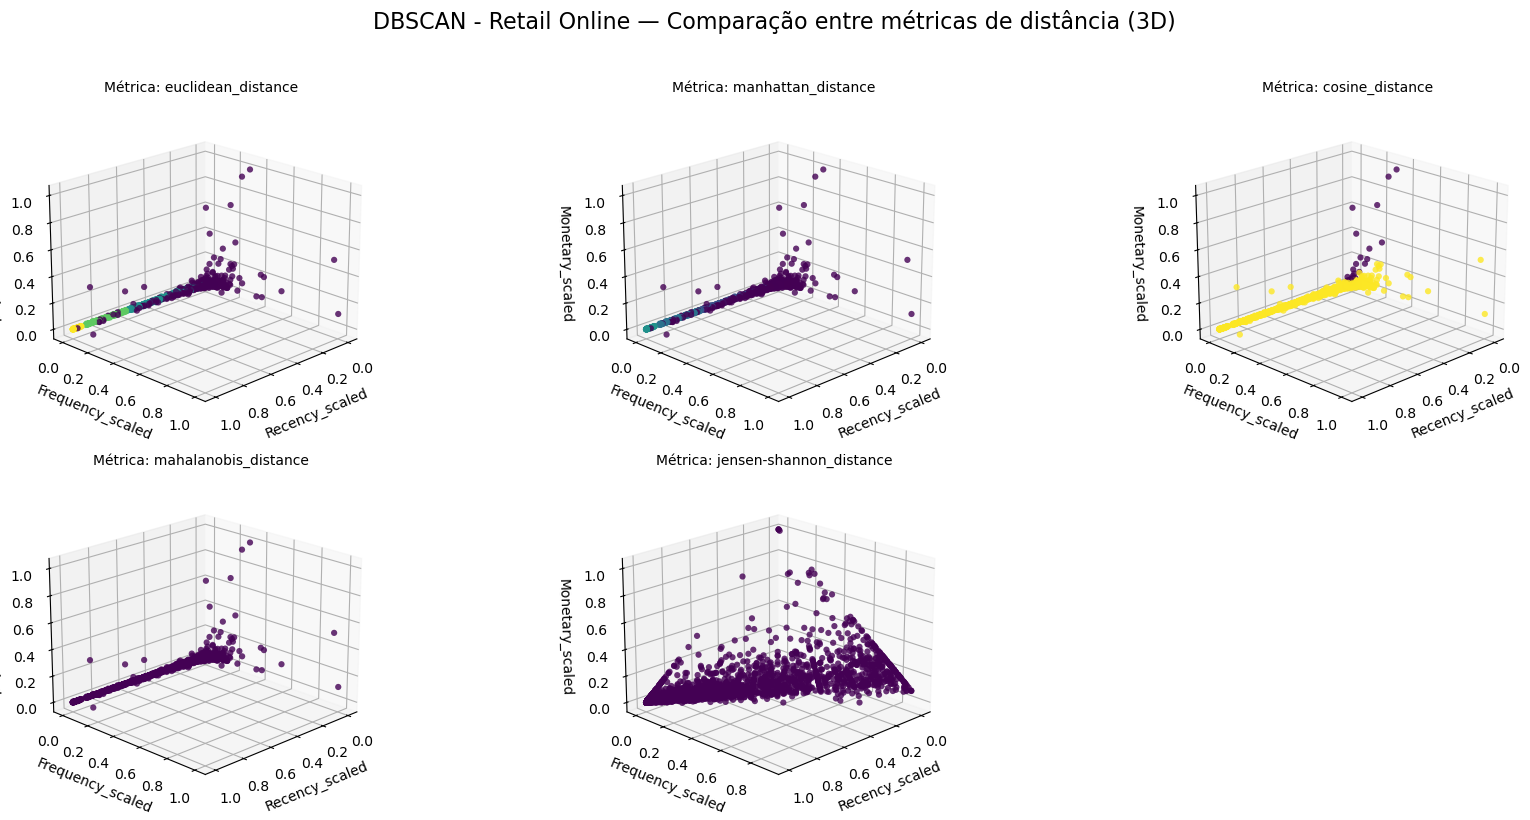

In [49]:
plot_algorithm_all_metrics_3d(plot_dict=plots_dbscan, algorithm_name="DBSCAN - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [50]:
#results_dbscan.pop()
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean_distance,3,114.910739,90.629982,0.279916,1.696048,2823.465930
1,DBSCAN,manhattan_distance,7,137.724108,85.981440,-0.371501,2.091660,1169.617850
2,DBSCAN,cosine_distance,1,276.467882,316.972343,0.188159,1.429677,38.020394
3,DBSCAN,mahalanobis_distance,0,83.226533,0.000000,NaN,NaN,NaN
4,DBSCAN,jensen-shannon_distance,1,1629.355660,608.170856,NaN,NaN,NaN


### Algoritmo: EM

In [ ]:
results_em = []
plots_em = {}
# instaciando the Expectation Maximization
for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    em.fit(X)
    runtime_em = time() - t0
    labels_em = em.labels_
    results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=silhouette_metric_name[metric_name], runtime=runtime_em, X=X, labels=labels_em))
    plots_em[metric_name] = {
        "X": X,
        "labels": labels_em,
        "model": em
    }
    print(f"Expectation Maximization com métrica {metric_name} finalizado.")

#Jensen-Shannon Distance vai usar um X diferente
em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name='jensen-shannon_distance')
t0 = time()
em.fit(X_jsd)
runtime_em = time() - t0
labels_em = em.labels_
results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=silhouette_metric_name['jensen-shannon_distance'], runtime=runtime_em, X=X_jsd, labels=labels_em))
plots_em['jensen-shannon_distance'] = {
        "X": X_jsd,
        "labels": labels_em,
        "model": em
    }
print(f"Expectation Maximization com métrica jensen-shannon_distance finalizado.")

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica euclidean_distance finalizado.
Expectation Maximization com métrica manhattan_distance finalizado.
Expectation Maximization com métrica cosine_distance finalizado.
Expectation Maximization com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica jensen-shannon_distance finalizado.


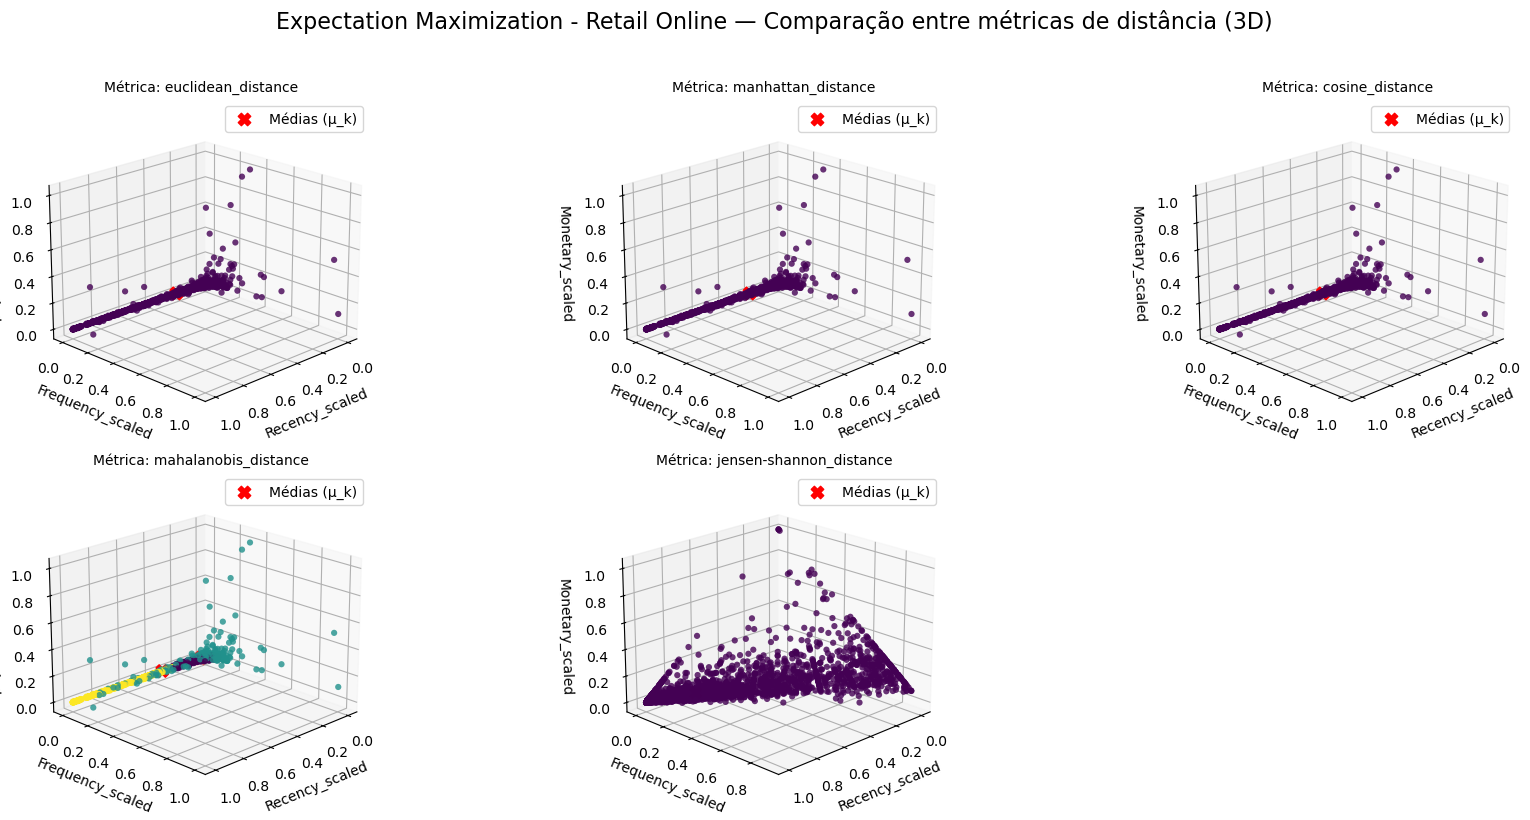

In [83]:
plot_algorithm_all_metrics_3d(plot_dict=plots_em, algorithm_name="Expectation Maximization - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [84]:
#results_em.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Expectation Maximization,euclidean_distance,1,0.563086,322.213555,NaN,NaN,NaN
1,Expectation Maximization,manhattan_distance,1,0.590842,322.213555,NaN,NaN,NaN
2,Expectation Maximization,cosine_distance,1,0.632028,322.213555,NaN,NaN,NaN
3,Expectation Maximization,mahalanobis_distance,3,0.125906,252.966985,0.037919,2.089135,593.326202
4,Expectation Maximization,jensen-shannon_distance,1,4.891727,608.170856,NaN,NaN,NaN


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}
# instaciando the Ward Method
for metric_name in metrics:
    ward = WardMethod(k=3, metric=metric_name)
    t0 = time()
    labels_ward = ward.fit_predict(X)
    runtime_ward = time() - t0
    results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))
    plots_ward[metric_name] = {
        "X": X,
        "labels": labels_ward,
        "model": ward
    }
    print(f"Ward Method com métrica {metric_name} finalizado.")

#Jensen-Shannon Distance vai usar um X diferente
ward = WardMethod(k=3, metric='jensen-shannon_distance')
t0 = time()
labels_ward = ward.fit_predict(X_jsd)
runtime_ward = time() - t0
results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name='jensen-shannon_distance', runtime=runtime_ward, X=X_jsd, labels=labels_ward))
plots_ward['jensen-shannon_distance'] = {
        "X": X_jsd,
        "labels": labels_ward,
        "model": ward
    }
print(f"Ward Method com métrica jensen-shannon_distance finalizado.")

In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_ward.pop()
df_results_ward = pd.DataFrame(results_ward)
df_results_ward

In [ ]:
ward_euc = plots_ward["euclidean_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["manhattan_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["mahalanobis_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["cosine_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["jensen-shannon_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)